# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

...

...

## Импорт библиотек, установка констант

In [69]:
%%capture
%pip install catboost -q

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

In [71]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [72]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и обзор данных

In [73]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [74]:
train.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
15396,41933.0,'Tain't What You Do (It's The Way That Cha Do It),0.911000,0.658,178067.0,0.2490,0.000026,F,0.1150,-11.111,Major,0.1280,80.891,4-Apr,0.853,Blues
2416,36523.0,"String Quartet No. 14 in D Minor, D. 810 ""Deat...",0.995000,0.459,251522.0,0.0976,0.876000,D,0.0825,-23.984,Major,0.0411,127.933,1-Apr,0.227,Classical
16921,86853.0,happiness,0.000116,0.506,131267.0,0.9830,0.704000,E,0.4310,-2.195,Major,0.1270,96.094,4-Apr,0.654,Anime
3788,69586.0,Zoom,0.035000,0.782,166027.0,0.5030,0.000000,D,0.2660,-8.214,Major,0.3050,129.904,4-Apr,0.657,Rap
11054,65663.0,GOD.,0.034700,0.706,248827.0,0.5570,0.000000,C,0.2760,-5.800,Major,0.0813,132.980,4-Apr,0.205,Rap


**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - тональность  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - наклонение  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

In [75]:
print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (20394, 16)
Test data shape: (5099, 15)


*Отметим отсутствие в тестовой выборке одного столбца (предположительно - целевого*

In [76]:
test.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
2168,70478,シークレットコード,0.00269,0.682,265311.0,0.692,0.000000,C#,0.2280,-3.983,Major,0.0309,134.950,4-Apr,0.851
763,67600,Freedom - TROY NōKA Remix,0.00830,0.561,232907.0,0.884,0.000000,D,0.3510,-5.310,Major,0.1510,154.157,4-Apr,0.331
3878,53347,Know Myself,0.47400,0.776,167493.0,0.500,0.000931,F,0.1690,-7.451,Minor,0.0579,100.055,4-Apr,0.544
2312,66032,B.Y.O.B.,0.00662,0.556,255467.0,0.981,0.000000,C#,0.2180,-2.688,Minor,0.1280,101.423,4-Apr,0.716
1809,68320,With a Billion Worldful of <3,0.12600,0.456,205480.0,0.678,0.000021,A#,0.0812,-6.417,Minor,0.0414,150.217,4-Apr,0.323


In [77]:
train.columns, test.columns

(Index(['instance_id', 'track_name', 'acousticness', 'danceability',
        'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',
        'music_genre'],
       dtype='object'),
 Index(['instance_id', 'track_name', 'acousticness', 'danceability',
        'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence'],
       dtype='object'))

*В тестовой выборке отсутствует целевая переменная. Это значит, что в ходе работы мы будем работать только с тренировочной выборкой (и делить ее на трейн и тест), а для тестовой только получим предстказание*

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

*Тренировочный датасет содержит пропуски в столбцах ``key``, ``mode``, ``tempo``. взглянем на тестовый датасет и решим, как с ними поступить*

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


*Видим пропуски в тех же столбцах, следовательно, будем закладывать обработку пропусков в пайплайн*

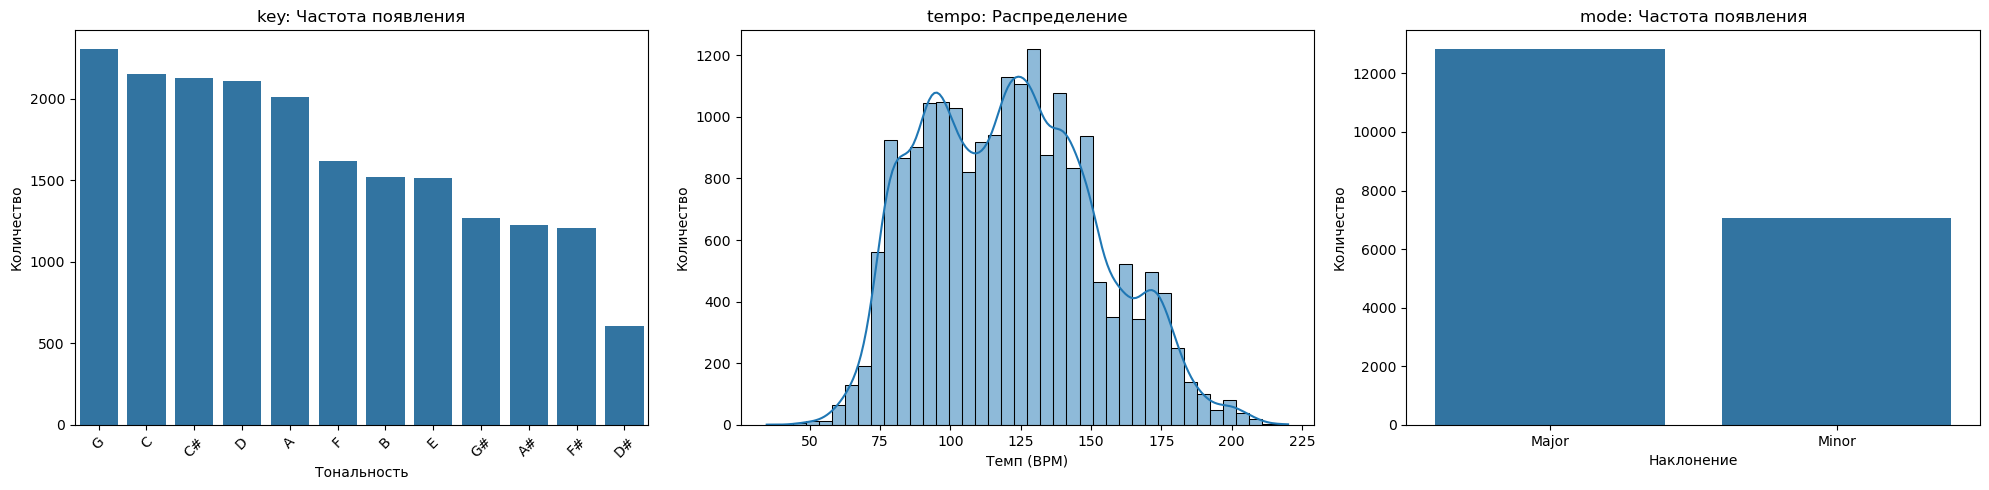

In [84]:
# Убираем пропуски
key_clean = train["key"].dropna()
tempo_clean = train["tempo"].dropna()
mode_clean = train["mode"].dropna()

# Преобразуем в строки (если нужно)
key_clean = key_clean.astype(str)
mode_clean = mode_clean.astype(str)

# Фигуры
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# key
sns.countplot(x=key_clean, ax=ax[0], order=key_clean.value_counts().index)
ax[0].set_title("key: Частота появления")
ax[0].set_xlabel("Тональность")
ax[0].set_ylabel("Количество")
ax[0].tick_params(axis='x', rotation=45)

# tempo
sns.histplot(tempo_clean, bins=40, kde=True, ax=ax[1])
ax[1].set_title("tempo: Распределение")
ax[1].set_xlabel("Темп (BPM)")
ax[1].set_ylabel("Количество")

# mode
sns.countplot(x=mode_clean, ax=ax[2], order=mode_clean.value_counts().index)
ax[2].set_title("mode: Частота появления")
ax[2].set_xlabel("Наклонение")
ax[2].set_ylabel("Количество")

plt.tight_layout()
plt.show();


*Для ``key`` и ``mode`` заменим пропуски модальным значением, для ``tempo`` - средним значением, т.к. распределение близко к нормальному*

In [88]:
# Создадим промежуточный датафрейм, с которым будем работать:

df_train = train.copy()

*Посмотрим на распределение целевой переменной*

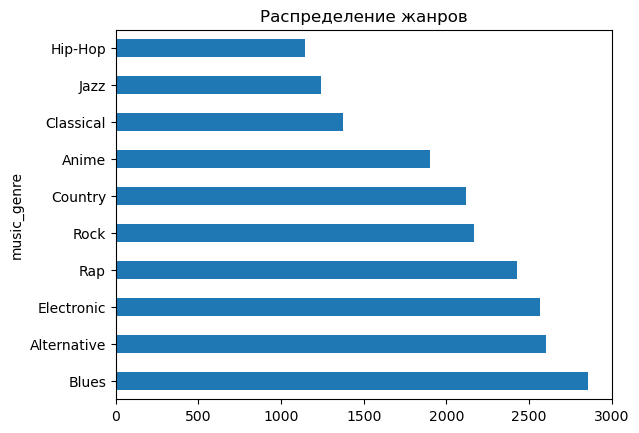

In [93]:
df_train["music_genre"].value_counts().plot(kind="barh", title="Распределение жанров");

*Видим, что у нас **умеренно несбалансированный** датасет. Нужно иметь это ввиду при обучении моделей

*Предобработаем датасет (уберем незначащие признаки ``instance_id``, ``track_name``, ``obtained_date`` и заполним пропуски*

In [94]:
# Удалим неинформативные признаки
df_train.drop(columns=["instance_id", "track_name", "obtained_date"], inplace=True)

# Посмотрим на количество пропусков
print(df_train.isnull().sum())

# Заполним пропуски:
# - числовой tempo — средним
# - категориальные key и mode — самым частым значением (модой)
df_train["tempo"].fillna(df_train["tempo"].mean(), inplace=True)
df_train["key"].fillna(df_train["key"].mode()[0], inplace=True)
df_train["mode"].fillna(df_train["mode"].mode()[0], inplace=True)

# Проверим снова
print("Пропуски после заполнения:\n", df_train.isnull().sum())


acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64
Пропуски после заполнения:
 acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64


C:\Users\izeme\AppData\Local\Temp\ipykernel_9344\2387266570.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["tempo"].fillna(df_train["tempo"].mean(), inplace=True)
C:\Users\izeme\AppData\Local\Temp\ipykernel_9344\2387266570.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

D## Разведочный анализ

## Работа с признаками

## Выбор и обучение моделей

## Оценка качества

## Анализ важности признаков модели